# End-to-End Quantitative Strategy Workflow

This notebook demonstrates a complete end-to-end workflow for a quantitative trading strategy, including:

1.  **Factor Calculation**: Running a deep learning model to generate predictive factor scores.
2.  **Portfolio Optimization**: Converting raw factor scores into optimized portfolio weights using a layered optimizer.
3.  **Backtesting**: Simulating the strategy's historical performance using the generated weights and a high-performance Rust-based backtester.

## Step 0: Setup and Imports

First, we import all necessary libraries and custom modules. We also add the project's root directory to the system path to ensure that our custom modules (`longgang_trader`) can be found.

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import polars as pl
import yaml
import torch
import json
import shutil

project_root = Path.cwd()
while not(project_root /'pyproject.toml').exists() and project_root != project_root.parent:
    project_root = project_root.parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
    print(f"Added {project_root} to sys.path")

Added d:\Notes\Project\LongGangTrader to sys.path


In [2]:

# Import custom modules using absolute imports (project_root is added to sys.path in an earlier cell).
from longgang_trader.alpha.dl_model_factor import inference_on_test_set, load_config
from longgang_trader.optimize.optimizer import LayeredOptimizer, EqualWeightOptimizer
from longgang_trader.backtesting.backtester import Backtester, TopNFactorStrategy

print("Setup complete. All modules imported.")

Setup complete. All modules imported.


## Step 1: Configuration

Here, we define all the paths and parameters for the entire workflow. This includes data paths, model paths, and settings for the optimizer and backtester. Keeping configuration in one place makes the workflow easy to manage and modify.

In [3]:
NOTEBOOK_ROOT = Path.cwd()
DATA_DIR = project_root / 'data'
TMP_DATA_DIR = NOTEBOOK_ROOT / 'tmp_workflow_data'

CONFIG = {
    # --- Data Paths ---
    # The DL dataloader expects a specific directory structure.
    # We will prepare this temporary directory in the next step.
    "data_root": str(TMP_DATA_DIR),
    "source_features_path": str(DATA_DIR / 'test_features.bin'),
    
    # --- Factor Calculation (Inference) ---
    "model_path": str(project_root/ 'notebooks' / 'AttentionGRU.pt'),
    "inference_output_path": str(NOTEBOOK_ROOT / 'preds_test_set.npy'),
    "dl_model_config": {
        "seq_len": 60,
        "hidden_dim": 128,
        "num_layers": 1,
        "dropout": 0.1,
        "batch_size": 1024,
        "num_workers": 0, # Use 0 for notebooks to avoid multiprocessing issues
        "device": "cuda:0" if torch.cuda.is_available() else "cpu",
    },
    
    # --- Optimization ---
    "optimizer_config": {
        "n_groups": 5, # For layered optimization
    },
    
    # --- Backtesting ---
    "backtest_config": {
        "initial_capital": 1_000_000,
        "transaction_cost": 0.001,
        "top_n": 10, # For the strategy
        "date_col": "date",
        "symbol_col": "order_book_id",
        "weight_col": "target_weight"
    }
}

print("Configuration loaded.")

Configuration loaded.


## Step 2: Factor Calculation (DL Model Inference)

In this step, we run our trained Attention GRU model on the test data to generate factor scores (predictions). 

Since the dataloader requires a specific directory layout (`<data_root>/features/*.bin`, `<data_root>/labels/*.bin`), we first prepare a temporary directory with a small sample of data in the required format. We then call the `inference_on_test_set` function.

In [4]:
# --- 1. Prepare a temporary, structured data directory for the dataloader ---
features_dir = TMP_DATA_DIR / "features"
labels_dir = TMP_DATA_DIR / "labels"
os.makedirs(features_dir, exist_ok=True)
os.makedirs(labels_dir, exist_ok=True)

DI, II, N_FEAT = 100, 50, 158 # Dummy dimensions for our sample data

# Create a small feature sample file
source_features_path = Path(CONFIG["source_features_path"])
sample_features_path = features_dir / "test_features.bin"
bytes_to_copy = DI * II * N_FEAT * 4 # 4 bytes for float32

if source_features_path.exists():
    print(f"Creating a small sample from {source_features_path}...")
    with open(source_features_path, 'rb') as f_in, open(sample_features_path, 'wb') as f_out:
        f_out.write(f_in.read(bytes_to_copy))
else:
    print(f"Warning: Source file not found at {source_features_path}. Creating a random dummy file.")
    dummy_features = np.random.rand(DI, II, N_FEAT).astype(np.float32)
    dummy_features.tofile(sample_features_path)

# Create the corresponding JSON metadata files
with open(f"{sample_features_path}.json", "w") as f:
    json.dump({"dtype": "float32", "shape": [DI, II, N_FEAT]}, f)

# Create dummy labels (required by the dataloader)
dummy_labels = np.random.rand(DI, II).astype(np.float32)
sample_labels_path = labels_dir / "test_labels.bin"
dummy_labels.tofile(sample_labels_path)
with open(f"{sample_labels_path}.json", "w") as f:
    json.dump({"dtype": "float32", "shape": [DI, II]}, f)

print(f"Temporary data prepared in: {TMP_DATA_DIR}")

# --- 2. Run inference ---
print("\nRunning inference on the test set...")
inference_on_test_set(
    model_path=CONFIG["model_path"],
    data_root=CONFIG["data_root"],
    output_file=CONFIG["inference_output_path"],
    **CONFIG["dl_model_config"]
)

# --- 3. Load and inspect the results ---
if Path(CONFIG["inference_output_path"]).exists():
    predictions = np.load(CONFIG["inference_output_path"])
    print(f"\nInference complete. Predictions saved with shape: {predictions.shape}")
else:
    print("\nError: Inference did not produce an output file.")

Creating a small sample from d:\Notes\Project\LongGangTrader\data\test_features.bin...
Temporary data prepared in: d:\Notes\Project\LongGangTrader\tests\tmp_workflow_data

Running inference on the test set...
推理设备: cpu
正在读取d:\Notes\Project\LongGangTrader\tests\tmp_workflow_data下的数据
原始数据维度: di=100, ii=50, n_feat=158, seq_len=60
有效的(di, ii)对数量: 287 / 2050 (14.00%)
有效样本数量: 287
特征数: 158, 序列长度: 60
Test set 尺寸: di=100, ii=50
加载模型: d:\Notes\Project\LongGangTrader\notebooks\AttentionGRU.pt
模型加载完毕


d:\Program Files\Conda\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


推理中[test]:   0%|          | 0/1 [00:00<?, ?it/s]

已保存2D预测矩阵到 d:\Notes\Project\LongGangTrader\tests\preds_test_set.npy, shape=(100, 50)

Inference complete. Predictions saved with shape: (100, 50)


## Step 3: Portfolio Optimization

Now we take the raw factor predictions from the model and convert them into portfolio weights. We use the `LayeredOptimizer` which first groups stocks by their factor scores and then applies an inner optimizer (`EqualWeightOptimizer` in this case) to assign weights within each group.

This requires us to:
1.  Load the 2D prediction matrix `(days, stocks)`.
2.  Convert it into a 'long' format Polars DataFrame: `(date, order_book_id, factor_value)`.
3.  Create mock market data (`stock_data`), as the optimizer requires it.
4.  Run the optimizer.

In [5]:
# --- 1. Load predictions ---
predictions = np.load(CONFIG["inference_output_path"])
n_dates, n_instruments = predictions.shape

# --- 2. Create mock mappings and convert to long format DataFrame ---
# In a real scenario, these would be loaded from your data source
dates = pd.to_datetime(pd.date_range(start="2024-01-01", periods=n_dates, freq='B'))
instruments = [f"INS_{i:04d}" for i in range(n_instruments)]

df_preds = pd.DataFrame(predictions, index=dates, columns=instruments)
factor_data_pd = df_preds.stack().reset_index()
factor_data_pd.columns = ['date', 'order_book_id', 'factor_value']

# Drop NaNs and convert to Polars DataFrame
factor_data_pd.dropna(inplace=True)
factor_data_pl = pl.from_pandas(factor_data_pd)

print("Factor data prepared for optimizer:")
print(factor_data_pl.head())

# --- 3. Create mock market data ---
# The optimizer needs a 'close' price column. We'll generate some random data.
market_data_pd = factor_data_pd[['date', 'order_book_id']].copy()
market_data_pd['close'] = np.random.uniform(10, 100, size=len(market_data_pd))
stock_data_pl = pl.from_pandas(market_data_pd)

print("\nMock market data prepared:")
print(stock_data_pl.head())

# --- 4. Run the optimizer ---
print("\nRunning layered portfolio optimization...")
layered_optimizer = LayeredOptimizer(
    optimizer=EqualWeightOptimizer(),
    config=CONFIG["optimizer_config"]
 )

optimized_weights_pl = layered_optimizer.optimize_layered_portfolio(
    stock_data=stock_data_pl,
    factor_data=factor_data_pl,
    weight_col='target_weight' # Name the output column for the backtester
 )

optimized_weights_pd = optimized_weights_pl.to_pandas()
print("\nOptimization complete. Resulting weights:")
print(optimized_weights_pd.head())

Factor data prepared for optimizer:
shape: (5, 3)
┌─────────────────────┬───────────────┬──────────────┐
│ date                ┆ order_book_id ┆ factor_value │
│ ---                 ┆ ---           ┆ ---          │
│ datetime[ns]        ┆ str           ┆ f32          │
╞═════════════════════╪═══════════════╪══════════════╡
│ 2024-03-27 00:00:00 ┆ INS_0016      ┆ -0.023019    │
│ 2024-03-28 00:00:00 ┆ INS_0016      ┆ -0.01263     │
│ 2024-03-29 00:00:00 ┆ INS_0016      ┆ -0.006384    │
│ 2024-04-01 00:00:00 ┆ INS_0016      ┆ -0.005645    │
│ 2024-04-02 00:00:00 ┆ INS_0016      ┆ -0.009573    │
└─────────────────────┴───────────────┴──────────────┘

Mock market data prepared:
shape: (5, 3)
┌─────────────────────┬───────────────┬───────────┐
│ date                ┆ order_book_id ┆ close     │
│ ---                 ┆ ---           ┆ ---       │
│ datetime[ns]        ┆ str           ┆ f64       │
╞═════════════════════╪═══════════════╪═══════════╡
│ 2024-03-27 00:00:00 ┆ INS_0016      ┆ 35.

## Step 4: Backtesting

Finally, we use the optimized weights to simulate the strategy's performance over time. 

The `Backtester` class takes a `strategy` object and market `data` as input. We will use the `TopNFactorStrategy`, which is a simple strategy that can be adapted to use our pre-calculated weights. The market data will be the same mock data we created in the previous step.

Setting up and running the backtest...
Rust 回测成功完成。

Backtest finished.
Plotting equity curve...


d:\Notes\Project\LongGangTrader\longgang_trader\backtesting\backtester.py:136: RuntimeWarning: invalid value encountered in scalar power
  annualized_return = (1 + total_return) ** (365.0 / days) - 1


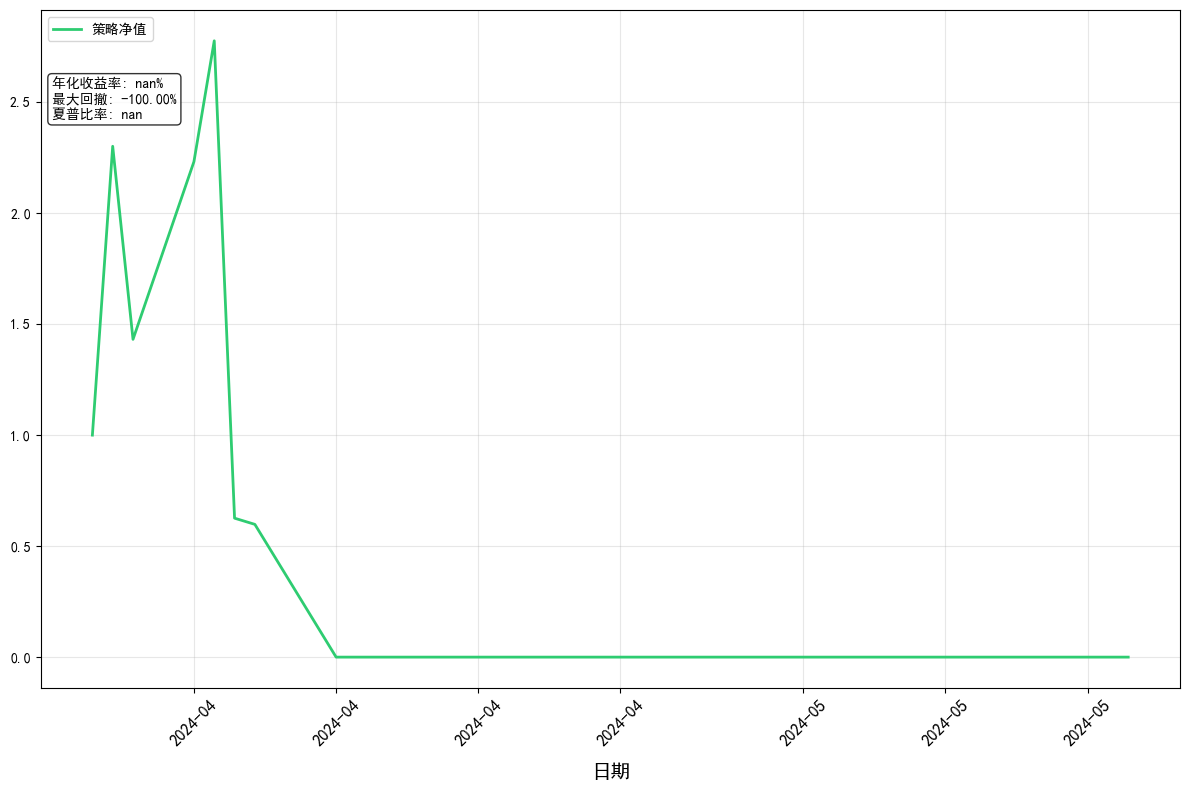

In [6]:
print("Setting up and running the backtest...")

# --- 1. Prepare data for the backtester ---
# The backtester's strategy needs the weights, and the backtester itself needs market data.
strategy_input_data = optimized_weights_pd.copy()
# Ensure date is datetime object
strategy_input_data['date'] = pd.to_datetime(strategy_input_data['date'])

# The market data needs to be in pandas format
market_data_pd = stock_data_pl.to_pandas()
market_data_pd['date'] = pd.to_datetime(market_data_pd['date'])

# --- 2. Define a Strategy that uses our pre-computed weights ---
# We can adapt the BaseStrategy to simply return the weights we already calculated.
class PrecomputedWeightStrategy(TopNFactorStrategy):
    def generate_signals_for_all_dates(self):
        # The 'factor_data' for this strategy is already our final weights table.
        # The optimizer has already named the column 'target_weight'.
        return self.factor_data[['date', 'order_book_id', 'target_weight']]

# --- 3. Run the backtest ---
strategy = PrecomputedWeightStrategy(
    factor_data=strategy_input_data, 
    config=CONFIG['backtest_config']
 )

backtester = Backtester(
    strategy=strategy,
    data=market_data_pd,
    config=CONFIG['backtest_config']
 )

# Run the high-performance backtest (calling Rust)
# NOTE: This requires the rust_core module to be compiled and installed.
# Run `maturin develop` in the project root directory first.
backtester.run_backtest()

print("\nBacktest finished.")

# --- 4. Plot results ---
print("Plotting equity curve...")
backtester.plot_equity_curve()

## Step 5: Clean up

Finally, we can remove the temporary data directory and inferred predictions file.

In [8]:
print(f"Cleaning up temporary directory: {TMP_DATA_DIR}")
if TMP_DATA_DIR.exists():
    shutil.rmtree(TMP_DATA_DIR)

inference_output_path = Path(CONFIG["inference_output_path"])
print(f"Cleaning up inference output: {inference_output_path}")
if inference_output_path.exists():
    os.remove(inference_output_path)

print("Cleanup complete.")

Cleaning up temporary directory: d:\Notes\Project\LongGangTrader\tests\tmp_workflow_data
Cleaning up inference output: d:\Notes\Project\LongGangTrader\tests\preds_test_set.npy
Cleanup complete.
